--- Starting Model Monitoring and Retraining Simulation ---
Loaded Sanctions Screening Model.
Loaded AML Isolation Forest Model and Scaler.

--- Simulating New Data for Monitoring (Drift: True) ---
  Introducing simulated drift: increasing average transaction amounts.
  Introducing simulated drift: increasing 'TRANSFER_OUT' transactions.
  Introducing simulated drift: more high-risk receiver countries.

Re-generating a small transaction training set to get AML scaler reference for monitoring...
New AML data scaled using reference scaler.

Re-generating a small test set for sanctions model monitoring...

--- Monitoring Performance for Sanctions Screening Model ---
Sanctions Model Performance (Sanctions Screening Model):
  Accuracy: 1.0000
  Precision (Sanctioned): 1.0000
  Recall (Sanctioned): 1.0000
  F1-Score (Sanctioned): 1.0000
  ROC AUC: 1.0000


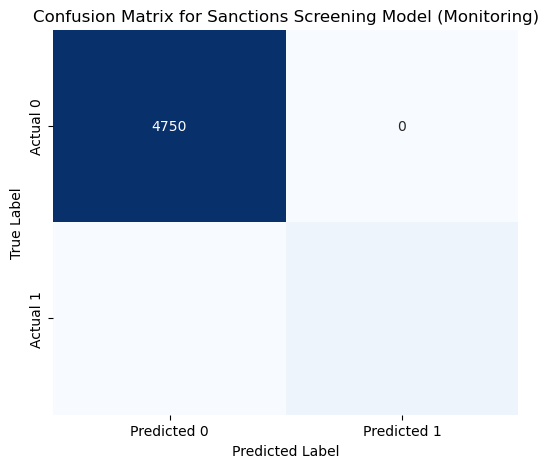


--- Monitoring Performance for AML Transaction Monitoring Model ---
AML Model Performance (AML Transaction Monitoring Model):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     49466
  Suspicious       0.25      0.31      0.28       534

    accuracy                           0.98     50000
   macro avg       0.62      0.65      0.63     50000
weighted avg       0.98      0.98      0.98     50000

  ROC AUC: 0.8429


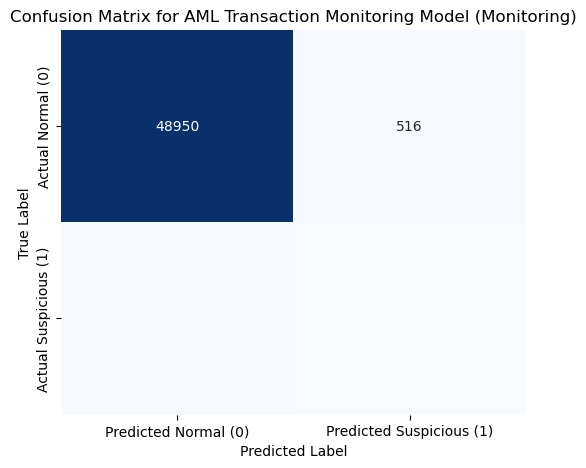


--- Running Data Drift Detection ---

--- Detecting Data Drift (Kolmogorov-Smirnov Test) ---
  Drift detected for feature 'Amount_USD': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Receiver_Country_Risk_Score': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Geographic_Risk_Score': p-value = 0.0049 (Threshold: 0.05)
  Drift detected for feature 'Total_Amount': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Avg_Amount': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Num_Transactions': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Max_Amount': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Min_Amount': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Unique_Counterparties': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'Amount_Geo_Risk_Interaction': p-value = 0.0000 (Threshold: 0.05)
  Drift detected for feature 'TxType_DEPOSIT': p-value = 0.002

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import joblib
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp # For simple data drift detection (Kolmogorov-Smirnov test)
import string
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.model_selection import GridSearchCV # Ensure GridSearchCV is imported if used in train_sanctions_model

# --- Configuration and Global Variables (consistent with previous steps) ---
NUM_CUSTOMERS = 500
NUM_TRANSACTIONS = 100000

# Country Risk Map (simulated external data)
COUNTRY_RISK_MAP = {
    'IRAN': 'HIGH', 'NORTH KOREA': 'HIGH', 'SYRIA': 'HIGH', 'CUBA': 'HIGH', 'VENEZUULA': 'HIGH',
    'RUSSIA': 'MEDIUM', 'CHINA': 'MEDIUM', 'INDIA': 'LOW', 'USA': 'LOW', 'UK': 'LOW',
    'GERMANY': 'LOW', 'FRANCE': 'LOW', 'BRAZIL': 'MEDIUM', 'SOUTH AFRICA': 'MEDIUM',
    'NIGERIA': 'MEDIUM', 'AFGHANISTAN': 'HIGH', 'YEMEN': 'HIGH', 'SOMALIA': 'HIGH',
    'LEBANON': 'MEDIUM', 'PAKISTAN': 'MEDIUM'
}
HIGH_RISK_COUNTRIES = [country for country, risk in COUNTRY_RISK_MAP.items() if risk == 'HIGH']
LOW_RISK_COUNTRIES = [country for country, risk in COUNTRY_RISK_MAP.items() if risk == 'LOW']

# --- Helper Functions (copied for self-containment and consistency) ---

def load_common_names_from_excel(filepath, sheet_name):
    try:
        names_df = pd.read_excel(filepath, sheet_name=sheet_name)
        if 'Sanctioned_name' in names_df.columns:
            return names_df['Sanctioned_name'].astype(str).tolist()
        else:
            return _get_default_common_names()
    except FileNotFoundError:
        return _get_default_common_names()
    except Exception as e:
        return _get_default_common_names()

def _get_default_common_names():
    return [
        'John Smith', 'Jane Johnson', 'Michael Williams', 'Emily Brown', 'David Jones',
        'Sarah Garcia', 'Chris Miller', 'Anna Davis', 'Robert Rodriguez', 'Maria Martinez',
        'William Taylor', 'Olivia Wilson', 'James Moore', 'Sophia White', 'Benjamin Green',
        'Isabella Hall', 'Lucas King', 'Mia Wright', 'Henry Lopez', 'Charlotte Hill'
    ]

def load_or_generate_initial_data(sanctions_csv_path='UK Sanctions List_mean.csv',
                                   customer_data_path='customer_data.csv',
                                   num_customers=None):
    if num_customers is None:
        num_customers = NUM_CUSTOMERS

    global COMMON_FULL_NAMES
    COMMON_FULL_NAMES = load_common_names_from_excel('Name_list.xlsx', 'Names')

    if not COMMON_FULL_NAMES:
        print("FATAL: COMMON_FULL_NAMES list is empty. Cannot proceed with data generation.")
        return pd.DataFrame(), pd.DataFrame()

    sanctions_df_cleaned = pd.DataFrame()
    customer_df = pd.DataFrame()

    try:
        raw_sanctions_df = pd.read_csv(sanctions_csv_path, encoding='latin1', header=1)
        # print(f"Successfully loaded {sanctions_csv_path} with 'latin1' encoding. Shape: {raw_sanctions_df.shape}")

        name_col = 'Name 6'
        address_col = 'Address 6'
        dob_col = 'DOB 6'
        nationality_col = 'Nationality 6'
        type_col = 'Type'
        id_col = 'ID'

        actual_name_col = name_col if name_col in raw_sanctions_df.columns else ('Name' if 'Name' in raw_sanctions_df.columns else None)
        actual_address_col = address_col if address_col in raw_sanctions_df.columns else ('Address' if 'Address' in raw_sanctions_df.columns else None)
        actual_dob_col = dob_col if dob_col in raw_sanctions_df.columns else ('DOB' if 'DOB' in raw_sanctions_df.columns else None)
        actual_nationality_col = nationality_col if nationality_col in raw_sanctions_df.columns else ('Nationality' if 'Nationality' in raw_sanctions_df.columns else None)
        actual_type_col = type_col if type_col in raw_sanctions_df.columns else ('Type' if 'Type' in raw_sanctions_df.columns else None)
        actual_id_col = id_col if id_col in raw_sanctions_df.columns else ('ID' if 'ID' in raw_sanctions_df.columns else None)

        if not actual_name_col:
            # print(f"FATAL: No suitable name column found in sanctions CSV. Using dummy data for sanctions.")
            raise ValueError("No name column found")

        sanctions_df_cleaned = raw_sanctions_df.copy()
        sanctions_df_cleaned['Sanctioned_Name'] = sanctions_df_cleaned[actual_name_col].astype(str).str.upper().str.strip()
        
        sanctions_df_cleaned['Sanctioned_Address'] = sanctions_df_cleaned[actual_address_col].astype(str).str.upper().str.strip() if actual_address_col and actual_address_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_DOB'] = pd.to_datetime(sanctions_df_cleaned[actual_dob_col], errors='coerce').dt.strftime('%Y-%m-%d') if actual_dob_col and actual_dob_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_Nationality'] = sanctions_df_cleaned[actual_nationality_col].astype(str).str.upper().str.strip() if actual_nationality_col and actual_nationality_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanction_Type'] = sanctions_df_cleaned[actual_type_col].astype(str).str.upper().str.strip() if actual_type_col and actual_type_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_ID'] = sanctions_df_cleaned[actual_id_col].astype(str) if actual_id_col and actual_id_col in sanctions_df_cleaned.columns else [f'S{i:04d}' for i in range(len(sanctions_df_cleaned))]

        sanctions_df_cleaned = sanctions_df_cleaned[[
            'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address',
            'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
        ]].copy()
        sanctions_df_cleaned = sanctions_df_cleaned[
            (sanctions_df_cleaned['Sanctioned_Name'] != 'UNKNOWN SANCTIONED NAME') &
            (sanctions_df_cleaned['Sanctioned_Name'] != 'NAN') &
            (sanctions_df_cleaned['Sanctioned_Name'].str.strip() != '')
        ].reset_index(drop=True)
        # print("Cleaned Sanctions Data (first 3 rows):")
        # print(sanctions_df_cleaned.head(3))
        # sanctions_df_cleaned.to_csv('sanctions_list_cleaned.csv', index=False)

    except FileNotFoundError:
        # print(f"Error: Sanctions file '{sanctions_csv_path}' not found. Generating minimal dummy sanctions data.")
        sanctions_df_cleaned = pd.DataFrame({
            'Sanctioned_ID': [f'S{i:04d}' for i in range(1, 101)],
            'Sanctioned_Name': [f'SANCTIONED PERSON {i}' for i in range(1, 101)],
            'Sanctioned_Address': [f'{i*10} MAIN ST, HIGH RISK COUNTRY' for i in range(1, 101)],
            'Sanctioned_DOB': [f'{1950 + i}-01-01' for i in range(100)],
            'Sanctioned_Nationality': random.choices(HIGH_RISK_COUNTRIES, k=100),
            'Sanction_Type': random.choices(['INDIVIDUAL', 'ENTITY'], k=100)
        })
        # print("Generated fallback sanctions data.")
    except Exception as e:
        # print(f"An unexpected error occurred during sanctions data loading/cleaning: {e}. Generating dummy sanctions data.")
        sanctions_df_cleaned = pd.DataFrame({
            'Sanctioned_ID': [f'S{i:04d}' for i in range(1, 101)],
            'Sanctioned_Name': [f'SANCTIONED PERSON {i}' for i in range(1, 101)],
            'Sanctioned_Address': [f'{i*10} MAIN ST, HIGH RISK COUNTRY' for i in range(1, 101)],
            'Sanctioned_DOB': [f'{1950 + i}-01-01' for i in range(100)],
            'Sanctioned_Nationality': random.choices(HIGH_RISK_COUNTRIES, k=100),
            'Sanction_Type': random.choices(['INDIVIDUAL', 'ENTITY'], k=100)
        })
        # print("Generated fallback sanctions data due to error.")


    try:
        customer_df = pd.read_csv(customer_data_path)
        # print(f"Successfully loaded customer data from {customer_data_path}. Shape: {customer_df.shape}")

        current_cols_lower = {col.lower(): col for col in customer_df.columns}
        
        expected_customer_cols_mapping = {
            'customer_id': 'Customer_ID',
            'customer_name': 'Customer_Name',
            'customer_address': 'Customer_Address',
            'customer_dob': 'Customer_DOB',
            'customer_nationality': 'Customer_Nationality',
            'customer_country': 'Customer_Country',
            'customer_industry': 'Customer_Industry',
            'onboarding_date': 'Onboarding_Date'
        }
        
        rename_dict = {}
        for old_col_lower, new_col_proper in expected_customer_cols_mapping.items():
            if old_col_lower in current_cols_lower:
                rename_dict[current_cols_lower[old_col_lower]] = new_col_proper
            elif new_col_proper not in customer_df.columns:
                # print(f"Warning: Customer column '{new_col_proper}' not found in loaded data. Creating as NaN.")
                customer_df[new_col_proper] = np.nan

        if rename_dict:
            customer_df.rename(columns=rename_dict, inplace=True)
            # print(f"Standardized customer column names: {rename_dict}")
            
        # print(f"Customer DataFrame columns after standardization: {customer_df.columns.tolist()}")

        required_customer_cols = ['Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country']
        if not all(col in customer_df.columns for col in required_customer_cols):
            missing_cols = [col for col in required_customer_cols if col not in customer_df.columns]
            # print(f"FATAL: Missing required customer columns after loading/standardization: {missing_cols}. Cannot proceed.")
            customer_df = pd.DataFrame() 

    except FileNotFoundError:
        # print(f"Customer data file '{customer_data_path}' not found. Generating dummy customer data.")
        customers = []
        for i in range(1, num_customers + 1):
            customer_id = f'CUST{i:05d}'
            customer_name = random.choice(COMMON_FULL_NAMES)
            customer_address = f"{random.randint(100, 999)} {random.choice(['Main St', 'Oak Ave', 'Pine Ln'])}"
            customer_dob = (datetime.date(1950, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 50))).strftime('%Y-%m-%d')
            customer_nationality = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_country = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_industry = random.choice(['Financial Services', 'Retail', 'Technology', 'Manufacturing', 'Healthcare'])
            onboarding_date = (datetime.date(2020, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 3))).strftime('%Y-%m-%d')

            if i % 10 == 0 and not sanctions_df_cleaned.empty:
                sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
                customer_name = sanctioned_entity['Sanctioned_Name'].replace('A', 'a', 1).replace('E', 'e', 1)
                customer_address = sanctioned_entity['Sanctioned_Address'].replace('ST', 'Street', 1)
                customer_dob = sanctioned_entity['Sanctioned_DOB']
                customer_nationality = sanctioned_entity['Sanctioned_Nationality']
                customer_country = sanctioned_entity['Sanctioned_Nationality']

            customers.append({
                'Customer_ID': customer_id,
                'Customer_Name': customer_name,
                'Customer_Address': customer_address,
                'Customer_DOB': customer_dob,
                'Customer_Nationality': customer_nationality,
                'Customer_Country': customer_country,
                'Customer_Industry': customer_industry,
                'Onboarding_Date': onboarding_date
            })
        customer_df = pd.DataFrame(customers)
        # customer_df.to_csv(customer_data_path, index=False)
        # print("Generated dummy customer data.")
    except Exception as e:
        # print(f"An unexpected error occurred during customer data loading/generation: {e}. Generating dummy customer data.")
        customers = []
        for i in range(1, num_customers + 1):
            customer_id = f'CUST{i:05d}'
            customer_name = random.choice(COMMON_FULL_NAMES)
            customer_address = f"{random.randint(100, 999)} {random.choice(['Main St', 'Oak Ave', 'Pine Ln'])}"
            customer_dob = (datetime.date(1950, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 50))).strftime('%Y-%m-%d')
            customer_nationality = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_country = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_industry = random.choice(['Financial Services', 'Retail', 'Technology', 'Manufacturing', 'Healthcare'])
            onboarding_date = (datetime.date(2020, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 3))).strftime('%Y-%m-%d')
            customers.append({
                'Customer_ID': customer_id, 'Customer_Name': customer_name, 'Customer_Address': customer_address,
                'Customer_DOB': customer_dob, 'Customer_Nationality': customer_nationality, 'Customer_Country': customer_country,
                'Customer_Industry': customer_industry, 'Onboarding_Date': onboarding_date
            })
        customer_df = pd.DataFrame(customers)
        # print("Generated fallback customer data due to error.")

    return sanctions_df_cleaned, customer_df

def calculate_sanctions_features(df):
    expected_input_cols = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
    ]
    if df.empty:
        all_expected_output_cols = expected_input_cols + [
            'Customer_Name_Clean', 'Sanctioned_Name_Clean', 'Customer_Address_Clean', 'Sanctioned_Address_Clean',
            'Customer_Nationality_Clean', 'Sanctioned_Nationality_Clean', 'Customer_Country_Clean',
            'name_fuzz_ratio', 'name_token_sort_ratio', 'name_token_set_ratio', 'name_match_score',
            'address_match_score', 'dob_match', 'nationality_match', 'customer_country_risk_score',
            'sanction_type_severity_score', 'name_country_interaction', 'name_dob_interaction'
        ]
        if 'is_sanction_match' in df.columns:
            all_expected_output_cols.append('is_sanction_match')
        return pd.DataFrame(columns=all_expected_output_cols)

    for col in expected_input_cols:
        if col not in df.columns:
            df[col] = np.nan

    df['Customer_Name_Clean'] = df['Customer_Name'].astype(str).str.upper().str.strip()
    df['Sanctioned_Name_Clean'] = df['Sanctioned_Name'].astype(str).str.upper().str.strip()
    df['Customer_Address_Clean'] = df['Customer_Address'].astype(str).str.upper().str.strip()
    df['Sanctioned_Address_Clean'] = df['Sanctioned_Address'].astype(str).str.upper().str.strip()
    df['Customer_Nationality_Clean'] = df['Customer_Nationality'].astype(str).str.upper().str.strip()
    df['Sanctioned_Nationality_Clean'] = df['Sanctioned_Nationality'].astype(str).str.upper().str.strip()
    df['Customer_Country_Clean'] = df['Customer_Country'].astype(str).str.upper().str.strip()

    df['name_fuzz_ratio'] = df.apply(lambda row: fuzz.ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1)
    df['name_token_sort_ratio'] = df.apply(lambda row: fuzz.token_sort_ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1)
    df['name_token_set_ratio'] = df.apply(lambda row: fuzz.token_set_ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1)
    df['name_match_score'] = df[['name_fuzz_ratio', 'name_token_sort_ratio', 'name_token_set_ratio']].max(axis=1)
    df['address_match_score'] = df.apply(lambda row: fuzz.token_set_ratio(row['Customer_Address_Clean'], row['Sanctioned_Address_Clean']), axis=1)
    df['dob_match'] = df.apply(lambda row: 1 if (pd.notna(row['Customer_DOB']) and pd.notna(row['Sanctioned_DOB']) and str(row['Customer_DOB']) == str(row['Sanctioned_DOB'])) else 0, axis=1)
    df['nationality_match'] = df.apply(lambda row: 1 if (pd.notna(row['Customer_Nationality_Clean']) and pd.notna(row['Sanctioned_Nationality_Clean']) and row['Customer_Nationality_Clean'] == row['Sanctioned_Nationality_Clean']) else 0, axis=1)

    df['customer_country_risk_score'] = df['Customer_Country_Clean'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)

    sanction_type_severity = {
        'INDIVIDUAL': 10, 'ENTITY': 8, 'VESSEL': 5, 'AIRCRAFT': 5, 'NAN': 0, 'UNKNOWN': 0
    }
    df['sanction_type_severity_score'] = df['Sanction_Type'].map(sanction_type_severity).fillna(0)
    df['name_country_interaction'] = df['name_match_score'] * df['customer_country_risk_score']
    df['name_dob_interaction'] = df['name_match_score'] * df['dob_match']
    return df

def generate_transaction_data(customer_df, num_transactions=None):
    if num_transactions is None:
        num_transactions = NUM_TRANSACTIONS

    # print(f"\n--- Generating Simulated Transaction Data with {num_transactions} transactions ---")
    transactions = []
    transaction_types = ['DEPOSIT', 'WITHDRAWAL', 'TRANSFER_IN', 'TRANSFER_OUT', 'PAYMENT']
    currencies = ['USD', 'EUR', 'GBP', 'JPY']
    
    if customer_df.empty:
        # print("Warning: Customer DataFrame is empty. Cannot generate transaction data. Returning empty DataFrame.")
        return pd.DataFrame(columns=[
            'Transaction_ID', 'Customer_ID', 'Transaction_Date', 'Transaction_Type',
            'Amount', 'Currency', 'Sender_ID', 'Receiver_ID', 'Sender_Country',
            'Receiver_Country', 'Is_Suspicious_Label'
        ])

    customer_ids = customer_df['Customer_ID'].tolist()
    customer_countries = customer_df.set_index('Customer_ID')['Customer_Country'].to_dict()

    for i in range(num_transactions):
        trans_id = f'TRANS{i:07d}'
        customer_id = random.choice(customer_ids)
        trans_date = (datetime.date(2023, 1, 1) + datetime.timedelta(days=random.randint(0, 364))).strftime('%Y-%m-%d')
        trans_type = random.choice(transaction_types)
        amount = round(random.uniform(10, 10000), 2)
        currency = random.choice(currencies)
        
        sender_id = customer_id
        receiver_id = random.choice(customer_ids)
        while sender_id == receiver_id and trans_type in ['TRANSFER_IN', 'TRANSFER_OUT']:
            receiver_id = random.choice(customer_ids)

        sender_country = customer_countries.get(sender_id, random.choice(list(COUNTRY_RISK_MAP.keys())))
        receiver_country = customer_countries.get(receiver_id, random.choice(list(COUNTRY_RISK_MAP.keys())))

        is_suspicious = 0
        if random.random() < 0.01:
            is_suspicious = 1
            susp_type = random.choice(['large_amount', 'high_risk_country', 'structuring'])

            if susp_type == 'large_amount':
                amount = round(random.uniform(50000, 1000000), 2)
            elif susp_type == 'high_risk_country':
                if trans_type in ['TRANSFER_OUT', 'PAYMENT']:
                    receiver_country = random.choice(HIGH_RISK_COUNTRIES)
                else:
                    sender_country = random.choice(HIGH_RISK_COUNTRIES)
                amount = round(random.uniform(5000, 50000), 2)
            elif susp_type == 'structuring':
                amount = round(random.uniform(8000, 9900), 2)
                trans_type = random.choice(['DEPOSIT', 'WITHDRAWAL'])

        transactions.append({
            'Transaction_ID': trans_id,
            'Customer_ID': customer_id,
            'Transaction_Date': trans_date,
            'Transaction_Type': trans_type,
            'Amount': amount,
            'Currency': currency,
            'Sender_ID': sender_id,
            'Receiver_ID': receiver_id,
            'Sender_Country': sender_country,
            'Receiver_Country': receiver_country,
            'Is_Suspicious_Label': is_suspicious
        })

    transaction_df = pd.DataFrame(transactions)
    transaction_df['Transaction_Date'] = pd.to_datetime(transaction_df['Transaction_Date'])
    
    # print(f"Generated {len(transaction_df)} transactions.")
    # print(f"Simulated Suspicious Transactions: {transaction_df['Is_Suspicious_Label'].sum()}")
    # print("Sample of Transaction Data:")
    # print(transaction_df.head())
    # transaction_df.to_csv('transaction_data.csv', index=False)
    return transaction_df

def feature_engineer_transactions(transactions_df, customer_df):
    # print("\n--- Performing Feature Engineering for Transaction Monitoring ---")
    required_cols = ['Customer_ID', 'Transaction_Date', 'Amount', 'Transaction_Type', 'Sender_Country', 'Receiver_Country']
    for col in required_cols:
        if col not in transactions_df.columns:
            # print(f"Warning: Missing column '{col}' in transactions_df for feature engineering. Adding as NaN.")
            transactions_df[col] = np.nan

    transactions_df['Transaction_Date'] = pd.to_datetime(transactions_df['Transaction_Date'], errors='coerce')
    transactions_df.dropna(subset=['Transaction_Date'], inplace=True)

    transactions_df['Amount_USD'] = transactions_df['Amount']
    transactions_df['Transaction_Hour'] = transactions_df['Transaction_Date'].dt.hour
    transactions_df['Transaction_DayOfWeek'] = transactions_df['Transaction_Date'].dt.dayofweek

    transactions_df['Sender_Country_Risk_Score'] = transactions_df['Sender_Country'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)
    transactions_df['Receiver_Country_Risk_Score'] = transactions_df['Receiver_Country'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)
    transactions_df['Geographic_Risk_Score'] = transactions_df[['Sender_Country_Risk_Score', 'Receiver_Country_Risk_Score']].max(axis=1)

    transactions_df = pd.get_dummies(transactions_df, columns=['Transaction_Type'], prefix='TxType', dummy_na=False)

    customer_agg_features = transactions_df.groupby('Customer_ID').agg(
        Total_Amount=('Amount_USD', 'sum'),
        Avg_Amount=('Amount_USD', 'mean'),
        Num_Transactions=('Transaction_ID', 'count'),
        Max_Amount=('Amount_USD', 'max'),
        Min_Amount=('Amount_USD', 'min'),
        Unique_Counterparties=('Receiver_ID', lambda x: x.nunique()),
    ).reset_index()

    transactions_df_features = pd.merge(transactions_df, customer_agg_features, on='Customer_ID', how='left')
    transactions_df_features['Amount_Geo_Risk_Interaction'] = transactions_df_features['Amount_USD'] * transactions_df_features['Geographic_Risk_Score']

    model_features = [
        'Amount_USD', 'Transaction_Hour', 'Transaction_DayOfWeek',
        'Sender_Country_Risk_Score', 'Receiver_Country_Risk_Score', 'Geographic_Risk_Score',
        'Total_Amount', 'Avg_Amount', 'Num_Transactions', 'Max_Amount', 'Min_Amount', 'Unique_Counterparties',
        'Amount_Geo_Risk_Interaction'
    ]
    
    for col in transactions_df_features.columns:
        if col.startswith('TxType_'):
            model_features.append(col)
    
    # Ensure all model_features exist, fill with 0 if not (e.g., if a TxType was never generated in a small sample)
    for feature in model_features:
        if feature not in transactions_df_features.columns:
            transactions_df_features[feature] = 0

    # print(f"Features created. Sample of features (first 5 rows):")
    # print(transactions_df_features[model_features].head())
    
    return transactions_df_features, model_features

def train_aml_model(X_train_scaled, contamination_rate=0.01):
    # print(f"\n--- Training Isolation Forest Model with contamination={contamination_rate} ---")
    model = IsolationForest(random_state=42, contamination=contamination_rate, n_estimators=200, max_features=1.0)
    model.fit(X_train_scaled)
    # print("Isolation Forest model trained.")
    return model

def train_sanctions_model(X_train, y_train, model_type='GradientBoosting'):
    # print(f"\n--- Training {model_type} Model ---")
    if model_type == 'LogisticRegression':
        model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    elif model_type == 'GradientBoosting':
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    else:
        raise ValueError("model_type must be 'LogisticRegression' or 'GradientBoosting'")

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0) # verbose=0 to reduce output
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


def generate_and_label_training_data(customer_df, sanctions_df_cleaned, num_samples=20000):
    expected_training_df_cols = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type',
        'is_sanction_match'
    ]
    if customer_df.empty or sanctions_df_cleaned.empty:
        return pd.DataFrame(columns=expected_training_df_cols)
    
    if len(customer_df) < 1 or len(sanctions_df_cleaned) < 1:
        return pd.DataFrame(columns=expected_training_df_cols)

    training_samples = []
    num_true_positives = int(num_samples * 0.05)
    for _ in range(num_true_positives):
        sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
        customer_entity = customer_df.sample(1).iloc[0]
        cust_name_tp = sanctioned_entity['Sanctioned_Name']
        if len(cust_name_tp) > 3:
            idx = random.randint(0, len(cust_name_tp) - 1)
            cust_name_tp = cust_name_tp[:idx] + random.choice(string.ascii_uppercase) + cust_name_tp[idx+1:]
        cust_address_tp = sanctioned_entity['Sanctioned_Address']
        if len(cust_address_tp) > 5:
            idx = random.randint(0, len(cust_address_tp) - 1)
            cust_address_tp = cust_address_tp[:idx] + random.choice(string.ascii_uppercase) + cust_address_tp[idx+1:]
        cust_dob_tp = sanctioned_entity['Sanctioned_DOB']
        cust_nationality_tp = sanctioned_entity['Sanctioned_Nationality']
        cust_country_tp = sanctioned_entity['Sanctioned_Nationality']
        training_samples.append({
            'Customer_ID': customer_entity['Customer_ID'], 'Customer_Name': cust_name_tp, 'Customer_Address': cust_address_tp,
            'Customer_DOB': cust_dob_tp, 'Customer_Nationality': cust_nationality_tp, 'Customer_Country': cust_country_tp,
            'Sanctioned_ID': sanctioned_entity['Sanctioned_ID'], 'Sanctioned_Name': sanctioned_entity['Sanctioned_Name'],
            'Sanctioned_Address': sanctioned_entity['Sanctioned_Address'], 'Sanctioned_DOB': sanctioned_entity['Sanctioned_DOB'],
            'Sanctioned_Nationality': sanctioned_entity['Sanctioned_Nationality'], 'Sanction_Type': sanctioned_entity['Sanction_Type'],
            'is_sanction_match': 1
        })

    num_true_negatives = num_samples - num_true_positives
    for _ in range(num_true_negatives):
        sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
        customer_entity = customer_df.sample(1).iloc[0]
        cust_name_tn = random.choice(COMMON_FULL_NAMES)
        cust_address_tn = f"{random.randint(1000, 9999)} {random.choice(['Road', 'Lane', 'Square'])}"
        cust_dob_tn = (datetime.date(1940, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 60))).strftime('%Y-%m-%d')
        cust_nationality_tn = random.choice(list(COUNTRY_RISK_MAP.keys()))
        cust_country_tn = random.choice(list(COUNTRY_RISK_MAP.keys()))
        training_samples.append({
            'Customer_ID': customer_entity['Customer_ID'], 'Customer_Name': cust_name_tn, 'Customer_Address': cust_address_tn,
            'Customer_DOB': cust_dob_tn, 'Customer_Nationality': cust_nationality_tn, 'Customer_Country': cust_country_tn,
            'Sanctioned_ID': sanctioned_entity['Sanctioned_ID'], 'Sanctioned_Name': sanctioned_entity['Sanctioned_Name'],
            'Sanctioned_Address': sanctioned_entity['Sanctioned_Address'], 'Sanctioned_DOB': sanctioned_entity['Sanctioned_DOB'],
            'Sanctioned_Nationality': sanctioned_entity['Sanctioned_Nationality'], 'Sanction_Type': sanctioned_entity['Sanction_Type'],
            'is_sanction_match': 0
        })
    
    training_df = pd.DataFrame(training_samples, columns=expected_training_df_cols)
    required_cols_for_features_input = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
    ]
    for col in required_cols_for_features_input:
        if col not in training_df.columns:
            training_df[col] = np.nan

    training_df_features = calculate_sanctions_features(training_df.copy())
    
    if 'is_sanction_match' not in training_df_features.columns:
        if 'is_sanction_match' in training_df.columns:
            training_df_features['is_sanction_match'] = training_df['is_sanction_match']
        else:
            training_df_features['is_sanction_match'] = 0

    feature_cols = [
        'name_match_score', 'address_match_score', 'dob_match',
        'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
        'name_country_interaction', 'name_dob_interaction'
    ]
    for col in feature_cols:
        if col not in training_df_features.columns:
            training_df_features[col] = 0

    training_df_features[feature_cols] = training_df_features[feature_cols].fillna(0)
    return training_df_features

# --- New Functions for Model Monitoring and Retraining (Step 6) ---

def monitor_model_performance(model_type, model_filename, X_test, y_test_true, model_name="Model"):
    """
    Monitors the performance of a given model (Sanctions or AML).
    For AML, y_test_true would be 'Is_Suspicious_Label'.
    """
    print(f"\n--- Monitoring Performance for {model_name} ---")
    
    try:
        model = joblib.load(model_filename)
    except FileNotFoundError:
        print(f"Error: Model file '{model_filename}' not found. Cannot monitor performance.")
        return

    if model_type == 'Sanctions':
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        report = classification_report(y_test_true, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test_true, y_proba)

        print(f"Sanctions Model Performance ({model_name}):")
        print(f"  Accuracy: {report['accuracy']:.4f}")
        print(f"  Precision (Sanctioned): {report['1']['precision']:.4f}")
        print(f"  Recall (Sanctioned): {report['1']['recall']:.4f}")
        print(f"  F1-Score (Sanctioned): {report['1']['f1-score']:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix for {model_name} (Monitoring)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    elif model_type == 'AML':
        # For Isolation Forest, decision_function provides anomaly scores
        anomaly_scores = model.decision_function(X_test)
        # Convert to binary predictions based on the contamination threshold used during training (or a default)
        # Isolation Forest outputs -1 for outliers, 1 for inliers.
        # We need to map -1 to 1 (suspicious) and 1 to 0 (normal) for classification report.
        y_pred_aml = np.where(model.predict(X_test) == -1, 1, 0)

        print(f"AML Model Performance ({model_name}):")
        # Note: For anomaly detection, the 'true' labels are often sparse, so metrics need careful interpretation.
        print(classification_report(y_test_true, y_pred_aml, target_names=['Normal', 'Suspicious']))
        
        try:
            # ROC AUC requires scores, not just binary predictions. Use -anomaly_scores as 'probability' of anomaly.
            roc_auc = roc_auc_score(y_test_true, -anomaly_scores)
            print(f"  ROC AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"  Could not compute ROC AUC: {e}. (Often due to only one class present in true labels/predictions)")

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test_true, y_pred_aml)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted Normal (0)', 'Predicted Suspicious (1)'],
                    yticklabels=['Actual Normal (0)', 'Actual Suspicious (1)'])
        plt.title(f'Confusion Matrix for {model_name} (Monitoring)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    else:
        print("Invalid model_type for monitoring.")

def detect_data_drift(reference_data, new_data, feature_names, threshold=0.05):
    """
    Detects data drift for numerical features using the Kolmogorov-Smirnov test.
    Compares the distribution of each feature in new data against reference data.
    A low p-value (e.g., < threshold) suggests significant drift.
    """
    print("\n--- Detecting Data Drift (Kolmogorov-Smirnov Test) ---")
    drift_detected = False
    drifted_features = []

    for feature in feature_names:
        if feature not in reference_data.columns or feature not in new_data.columns:
            print(f"  Warning: Feature '{feature}' not found in both reference or new data. Skipping drift check.")
            continue
        
        # Ensure data is numeric and handle NaNs for KS test
        ref_series = pd.to_numeric(reference_data[feature].dropna(), errors='coerce')
        new_series = pd.to_numeric(new_data[feature].dropna(), errors='coerce')

        if ref_series.empty or new_series.empty:
            print(f"  Warning: Skipping drift check for '{feature}' due to empty or all-NaN data after dropping NaNs.")
            continue

        # Perform KS test
        statistic, p_value = ks_2samp(ref_series, new_series)
        
        if p_value < threshold:
            print(f"  Drift detected for feature '{feature}': p-value = {p_value:.4f} (Threshold: {threshold})")
            drift_detected = True
            drifted_features.append(feature)
        # else:
            # print(f"  No significant drift for feature '{feature}': p-value = {p_value:.4f}")
            
    if not drift_detected:
        print("No significant data drift detected across monitored features.")
    else:
        print(f"\nSummary: Data drift detected for the following features: {', '.join(drifted_features)}")
    return drift_detected, drifted_features

def simulate_new_data_with_drift(customer_df, sanctions_df, num_transactions=20000, introduce_drift=False):
    """
    Simulates new transaction data, optionally introducing drift.
    """
    print(f"\n--- Simulating New Data for Monitoring (Drift: {introduce_drift}) ---")
    new_transactions_df = generate_transaction_data(customer_df, num_transactions=num_transactions)

    if introduce_drift and not new_transactions_df.empty:
        # Example of introducing drift: increase average transaction amount
        print("  Introducing simulated drift: increasing average transaction amounts.")
        new_transactions_df['Amount'] = new_transactions_df['Amount'] * np.random.uniform(1.2, 1.5, len(new_transactions_df))
        
        # Example of introducing drift: shift in transaction types (more transfers)
        print("  Introducing simulated drift: increasing 'TRANSFER_OUT' transactions.")
        transfer_out_indices = new_transactions_df.sample(frac=0.1, random_state=42).index # 10% of data
        new_transactions_df.loc[transfer_out_indices, 'Transaction_Type'] = 'TRANSFER_OUT'

        # Example of introducing drift: more high-risk countries
        print("  Introducing simulated drift: more high-risk receiver countries.")
        high_risk_indices = new_transactions_df.sample(frac=0.05, random_state=42).index # 5% of data
        if HIGH_RISK_COUNTRIES:
            new_transactions_df.loc[high_risk_indices, 'Receiver_Country'] = random.choice(HIGH_RISK_COUNTRIES)
        else:
            print("  Warning: Cannot introduce high-risk country drift as HIGH_RISK_COUNTRIES is empty.")

    return new_transactions_df

# --- Main Execution Flow for Model Monitoring and Retraining ---
if __name__ == "__main__":
    print("--- Starting Model Monitoring and Retraining Simulation ---")

    # 1. Load Initial Data (for generating new data and context)
    sanctions_df, customer_df = load_or_generate_initial_data()
    if customer_df.empty:
        print("FATAL: Customer data is empty. Cannot proceed with monitoring simulation. Exiting.")
        exit()

    # 2. Load Trained Models and Scalers (from previous steps)
    try:
        sanctions_model = joblib.load('sanctions_screening_gb_model.joblib')
        print("Loaded Sanctions Screening Model.")
    except FileNotFoundError:
        print("Warning: Sanctions model not found. Cannot perform sanctions monitoring. Skipping.")
        sanctions_model = None

    try:
        aml_model = joblib.load('aml_isolation_forest_model.joblib')
        aml_scaler = joblib.load('aml_scaler.joblib')
        print("Loaded AML Isolation Forest Model and Scaler.")
    except FileNotFoundError:
        print("Warning: AML model or scaler not found. Cannot perform AML monitoring. Skipping.")
        aml_model = None
        aml_scaler = None

    # 3. Simulate New Data for Monitoring
    # We'll generate a fresh batch of transactions to simulate new incoming data.
    # Set introduce_drift=True to see the drift detection in action.
    new_transactions_raw = simulate_new_data_with_drift(customer_df.copy(), sanctions_df.copy(), num_transactions=50000, introduce_drift=True)
    
    if new_transactions_raw.empty:
        print("FATAL: New transaction data generation failed. Exiting monitoring simulation.")
        exit()

    # Feature engineer the new data using the same process
    new_transactions_features, aml_features_list = feature_engineer_transactions(new_transactions_raw.copy(), customer_df.copy())

    if new_transactions_features.empty or not aml_features_list:
        print("FATAL: Feature engineering for new transactions resulted in an empty DataFrame or no features. Exiting.")
        exit()

    # Prepare data for AML model monitoring
    X_new_aml = new_transactions_features[aml_features_list].fillna(0)
    y_new_aml_labels = new_transactions_features['Is_Suspicious_Label'] # True labels for evaluation

    # Scale new data using the *same scaler* that was fitted on the training data
    # In a real system, you'd load the pre-fitted scaler. For this simulation,
    # we'll re-fit it on the original training data for consistency if not loaded.
    
    # To get the original training data features and labels for scaling reference for AML:
    # Generate a fresh set of transaction data for the AML scaler reference
    print("\nRe-generating a small transaction training set to get AML scaler reference for monitoring...")
    aml_training_raw_ref = generate_transaction_data(customer_df.copy(), num_transactions=10000)
    if aml_training_raw_ref.empty:
        print("Warning: Could not re-generate reference transaction data for AML scaler. Skipping AML monitoring.")
        X_aml_ref = None
    else:
        aml_training_features_ref, _ = feature_engineer_transactions(aml_training_raw_ref.copy(), customer_df.copy())
        if aml_training_features_ref.empty:
            print("Warning: Feature engineering for AML reference data resulted in an empty DataFrame. Skipping AML monitoring.")
            X_aml_ref = None
        else:
            # Ensure the reference features match the aml_features_list
            # This is crucial if some TxType_ columns might be missing in small generated samples
            for feature in aml_features_list:
                if feature not in aml_training_features_ref.columns:
                    aml_training_features_ref[feature] = 0 # Add missing columns with 0

            X_aml_ref = aml_training_features_ref[aml_features_list].fillna(0)
            scaler_ref = StandardScaler()
            scaler_ref.fit(X_aml_ref) # Fit scaler on reference AML training data
            X_new_aml_scaled = scaler_ref.transform(X_new_aml) # Transform new data with reference scaler
            print("New AML data scaled using reference scaler.")


    # 4. Monitor Model Performance (Sanctions and AML)
    # For sanctions, we need to re-generate a 'test set' for monitoring
    # In a real system, you'd have new labeled data for this.
    print("\nRe-generating a small test set for sanctions model monitoring...")
    sanctions_test_data_ref = generate_and_label_training_data(customer_df.copy(), sanctions_df.copy(), num_samples=5000)
    if sanctions_test_data_ref.empty:
        print("Warning: Could not re-generate sanctions test data for monitoring. Skipping sanctions model monitoring.")
        X_sanctions_test = None
        y_sanctions_test = None
    else:
        sanctions_ml_features = [
            'name_match_score', 'address_match_score', 'dob_match',
            'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
            'name_country_interaction', 'name_dob_interaction'
        ]
        # Ensure all sanctions_ml_features exist in sanctions_test_data_ref
        for feature in sanctions_ml_features:
            if feature not in sanctions_test_data_ref.columns:
                sanctions_test_data_ref[feature] = 0 # Add missing columns with 0

        X_sanctions_test = sanctions_test_data_ref[sanctions_ml_features].fillna(0)
        y_sanctions_test = sanctions_test_data_ref['is_sanction_match']

    if sanctions_model and X_sanctions_test is not None and y_sanctions_test is not None:
        monitor_model_performance('Sanctions', 'sanctions_screening_gb_model.joblib', X_sanctions_test, y_sanctions_test, model_name="Sanctions Screening Model")
    else:
        print("Sanctions model or test data not available for monitoring.")

    if aml_model and X_new_aml_scaled is not None and y_new_aml_labels is not None:
        monitor_model_performance('AML', 'aml_isolation_forest_model.joblib', X_new_aml_scaled, y_new_aml_labels, model_name="AML Transaction Monitoring Model")
    else:
        print("AML model or scaled data not available for monitoring.")

    # 5. Detect Data Drift
    # We need a reference dataset for comparison. Use X_aml_ref (before scaling)
    print("\n--- Running Data Drift Detection ---")
    if X_aml_ref is not None and X_new_aml is not None and aml_features_list:
        drift_detected, drifted_features = detect_data_drift(X_aml_ref, X_new_aml, aml_features_list)

        if drift_detected:
            print("\nACTION REQUIRED: Significant data drift detected. Consider retraining models, especially AML.")
        else:
            print("\nNo significant data drift detected. Models likely performing as expected on current data distribution.")
    else:
        print("Cannot perform data drift detection due to missing reference or new AML data.")


    # 6. Retraining Strategy (Conceptual)
    print("\n--- Retraining Strategy (Conceptual) ---")
    if 'drift_detected' in locals() and drift_detected: # Check if drift_detected was set
        print("  Recommendation: Retrain AML model using new data to adapt to detected drift.")
        # In a real system, you'd trigger a retraining pipeline here.
        # For simulation, we can just print a message.
        # Example:
        # new_training_data = pd.concat([training_data_features_labels_ref, new_transactions_features], ignore_index=True)
        # retrained_aml_model = train_aml_model(scaler_ref.fit_transform(new_training_data[aml_features_list].fillna(0)), contamination_rate)
        # joblib.dump(retrained_aml_model, 'aml_isolation_forest_model_retrained.joblib')
        # print("  AML model has been conceptually retrained and saved as 'aml_isolation_forest_model_retrained.joblib'.")
    else:
        print("  No immediate retraining recommended based on current monitoring results.")

    print("\n--- Model Monitoring and Retraining Simulation Complete ---")
